In [1]:
"This notebook is for setting the threshold of genes that cannot be binarized in 1st step. The genes that are binarized with the method in 1st step are used as references. By using the correlation between genes with the reference genes, the genes that cannot be binarized in 1st step can be selected and binarized"

'This notebook is for setting the threshold of genes that cannot be binarized in 1st step. The genes that are binarized with the method in 1st step are used as references. By using the correlation between genes with the reference genes, the genes that cannot be binarized in 1st step can be selected and binarized'

In [2]:
import scvelo as scv
import pandas as pd 
import numpy as np
from anndata import AnnData
import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.patches as mpatches
import pickle
import os
import leidenalg
from scipy import sparse
from IPython.display import SVG
from sklearn.linear_model import LinearRegression
from scipy import stats,signal
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cross_decomposition import PLSRegression

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scanpy
from filter_dispersion import filter_dispersion
from scipy.sparse import issparse
from scvelo.preprocessing.utils import get_mean_var,materialize_as_ndarray
from scipy.cluster.hierarchy import dendrogram, linkage


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
data_path='../data/'
result_path='result/'
bin_result_path='bin_result/'

adata_all=scv.read(data_path+'DentateGyrus.loom', cache=True)
adata_all.var_names_make_unique()
adata0_P5=adata_all[(adata_all.obs['Age']=='P5'),:]
adata_P5=adata0_P5[adata0_P5.obs['SampleID']=='10X84_2',:]

In [ ]:
t_list=['RadialGlia','nIPC','Nbl1','Nbl2', 'ImmGranule1', 'ImmGranule2','Granule']
adata0=adata_P5[(adata_P5.obs['ClusterName']=='RadialGlia') \
                +(adata_P5.obs['ClusterName']=='nIPC')\
                +(adata_P5.obs['ClusterName']=='Nbl1')\
                +(adata_P5.obs['ClusterName']=='Nbl2')\
                +(adata_P5.obs['ClusterName']=='ImmGranule1')\
                +(adata_P5.obs['ClusterName']=='ImmGranule2')\
                +(adata_P5.obs['ClusterName']=='Granule'),:]


In [3]:
"selecting high dispersion genes"

'selecting high dispersion genes'

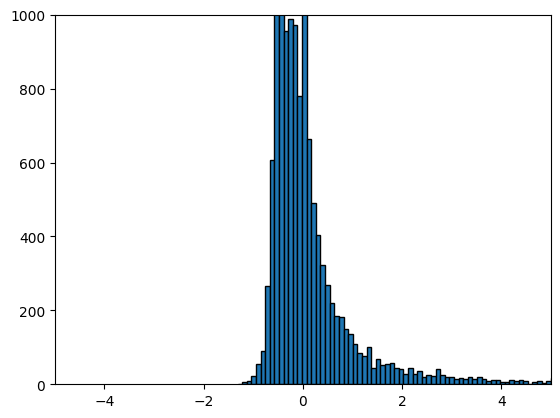

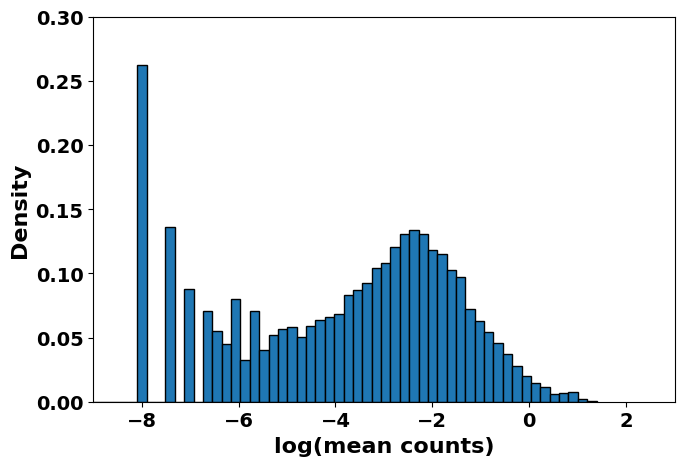

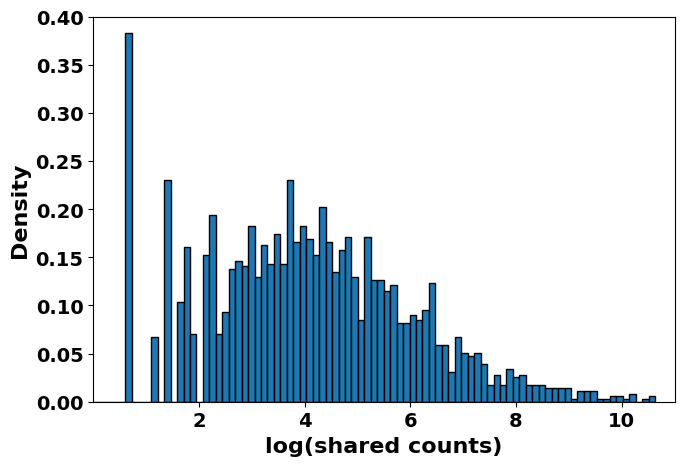

(2051,)

In [11]:
adata=adata0.copy()
adata,df,gene_subset=filter_dispersion(adata,n_bins=20,min_disp = 0.25,max_disp = np.inf,min_mean = 0.01,max_mean = 3)

plt.hist(df["dispersion_norm"].values,bins=200,edgecolor='k')
plt.axis([-5,5,0,1000])
plt.show()

plt.figure(figsize=(7.5,5))
plt.hist(np.log(df["mean"].values),bins=150,edgecolor='k',density=True)
plt.axis([-9,3,0,0.3])
plt.xlabel('log(mean counts)',fontsize=16,fontweight='bold')
plt.ylabel('Density',fontsize=16,fontweight='bold')
plt.xticks(np.arange(-8,3,2),fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'DG_mean_counts_distribution.png',dpi=300)
plt.show()

# adata.var.index.values[gene_subset].shape
hv_genes=adata.var.index.values[gene_subset]
adata=adata[:,hv_genes]

#----distribution of shared counts

Xs, Xu = adata.layers["spliced"], adata.layers["unspliced"]
nonzeros = (
    (Xs > 0).multiply(Xu > 0) if issparse(Xs) else (Xs > 0) * (Xu > 0)
            )
X = (
    nonzeros.multiply(Xs) + nonzeros.multiply(Xu)
    if issparse(nonzeros)
                else nonzeros * (Xs + Xu)
            )

# plt.hist(np.sum(X.A,axis=0),bins=100,edgecolor='k')
plt.figure(figsize=(7.5,5))
plt.hist(np.log(np.sum(X.A,axis=0)+1e-6),bins=200,edgecolor='k',density=True)
plt.axis([0,11,0,0.4])
plt.xlabel('log(shared counts)',fontsize=16,fontweight='bold')
plt.ylabel('Density',fontsize=16,fontweight='bold')
plt.xticks(np.arange(2,12,2),fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'DG_shared_counts_distribution.png',dpi=300)
plt.show()


np.where(np.log(np.sum(X.A,axis=0))>2)[0].shape

In [4]:
"preprocessign dataset"

'preprocessign dataset'

In [ ]:
adata=adata0[:,hv_genes]
scv.pp.filter_and_normalize(adata,min_shared_counts=10)
print(adata.X.shape)
scv.pp.neighbors(adata, n_neighbors=50)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=50)
scv.tl.umap(adata)
scv.tl.velocity(adata,mode='stochastic',perc=[5, 95])
scv.tl.velocity_graph(adata,xkey='Ms')

In [5]:
"computing correlation beween high dipersion genes"

'computing correlation beween high dipersion genes'

In [14]:
gene_arr=adata.var.index.values

In [15]:
bin_genes=np.load(bin_result_path+'DG_bin_genes.npy')
bin_genes_centers=np.load(bin_result_path+'DG_bin_genes_center.npy')
bin_gene_inds=np.where(np.in1d(gene_arr,bin_genes))[0]

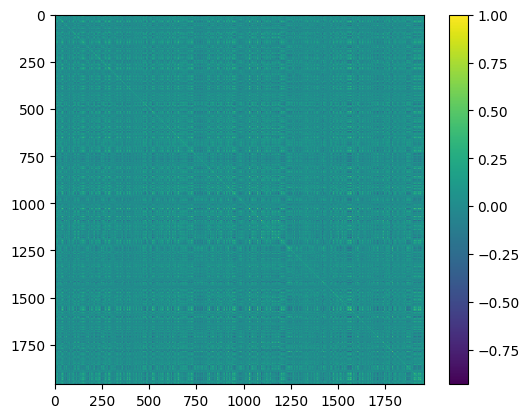

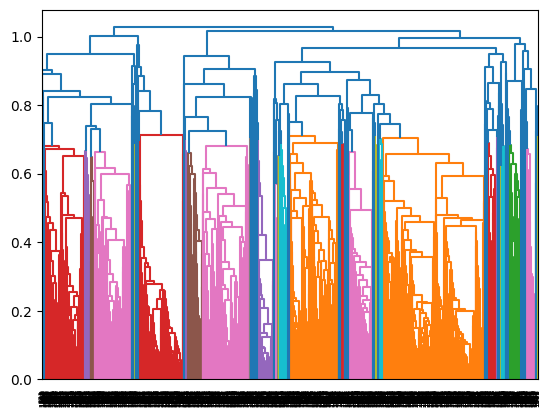

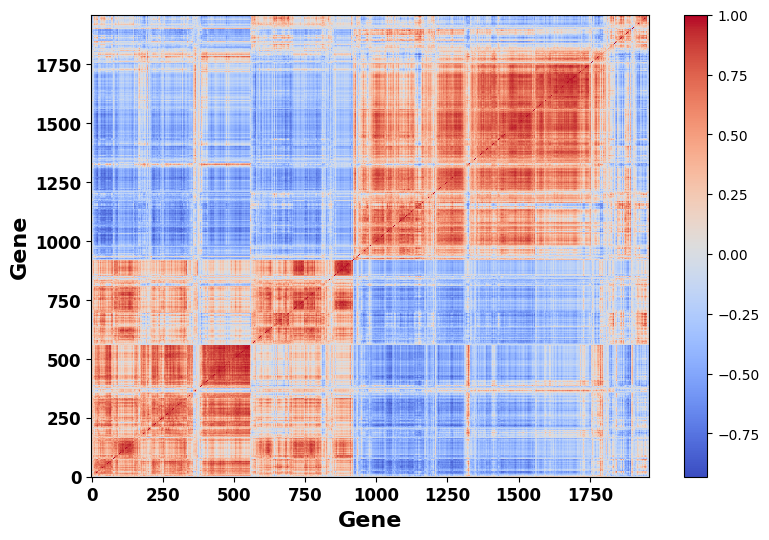

In [16]:
Xs=adata.layers['Ms']#adata.X.A#
scaler=StandardScaler()
X=scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)

plt.figure(figsize=(9,6))
plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')

plt.xlabel('Gene',fontsize=16,fontweight='bold')
plt.ylabel('Gene',fontsize=16,fontweight='bold')

plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.colorbar()
# plt.savefig(result_path+'EG_heatmap.png',dpi=300)
plt.show()

In [7]:
"find those highly binarized correlated genes that are mostly in ON/OFF state and determine the higher/lower center of current gene"

'find those highly binarized correlated genes that are mostly in ON/OFF state and determine the higher/lower center of current gene'

In [17]:
non_bin_genes=[]
gene_centers=[]
high_thres=[0.8,0.75,0.7,0.65,0.6,0.55,0.5]
low_thres=[0.2,0.25,0.3,0.35,0.4,0.45,0.5]
for gi in range(len(gene_arr)):
    g=gene_arr[gi]
    if g not in bin_genes:
        non_bin_genes.append(g)
        hc_gene_inds=np.argsort(X_corr[gi,:])[-30:]#index of highly correlated genes 
        hc_bin_gene_inds=hc_gene_inds[np.in1d(hc_gene_inds,bin_gene_inds)]# genes that are binarized in the highly correlated genes
        print(hc_bin_gene_inds.shape)
        if len(hc_bin_gene_inds)>2:
            
            X_hc=Xs[:,hc_bin_gene_inds]
            X_hc_thres=bin_genes_centers[np.where(np.in1d(hc_bin_gene_inds,bin_gene_inds))[0]]
            X_hc_bin=X_hc.copy()
            for hi in range(X_hc.shape[1]):
                gene_kc=X_hc_thres[hi,:]
                x=X_hc[:,hi]
                x_dist0=abs(x-gene_kc[0])
                x_dist1=abs(x-gene_kc[1])
                
                X_hc_bin[:,hi][x_dist0<x_dist1]=0
                X_hc_bin[:,hi][x_dist0>=x_dist1]=1

            g_center=[0,0]
            for lt in low_thres:
                #find those highly binarized correlated genes that are mostly 
                #in OFF state and determine the lower center of current gene
                if len(Xs[:,gi][(np.sum(X_hc_bin,axis=1)/X_hc_bin.shape[1])<=lt])>10:
                    g_center[0]=np.mean(Xs[:,gi][(np.sum(X_hc_bin,axis=1)/X_hc_bin.shape[1])<=lt])
                    break
                else:
                    continue

            for ht in high_thres:
                #find those highly binarized correlated genes that are mostly 
                #in ON state and determine the higher center of current gene
                if len(Xs[:,gi][(np.sum(X_hc_bin,axis=1)/X_hc_bin.shape[1])>=ht])>10:
                    g_center[1]=np.mean(Xs[:,gi][(np.sum(X_hc_bin,axis=1)/X_hc_bin.shape[1])>=ht])
                    break
                else:
                    continue
            
        gene_centers.append(g_center)

        
        
    else:
        bgi=np.where(bin_genes==g)[0][0]  
        gene_centers.append(bin_genes_centers[bgi,:])
        

gene_centers=np.array(gene_centers)             
            

(17,)
(7,)
(12,)
(20,)
(14,)
(21,)
(13,)
(18,)
(9,)
(9,)
(8,)
(6,)
(20,)
(21,)
(6,)
(23,)
(22,)
(6,)
(22,)
(15,)
(23,)
(19,)
(12,)
(19,)
(7,)
(18,)
(10,)
(18,)
(10,)
(10,)
(19,)
(27,)
(26,)
(16,)
(13,)
(5,)
(23,)
(25,)
(12,)
(21,)
(3,)
(18,)
(12,)
(11,)
(21,)
(22,)
(6,)
(21,)
(13,)
(11,)
(14,)
(9,)
(24,)
(19,)
(27,)
(8,)
(6,)
(13,)
(14,)
(10,)
(23,)
(15,)
(6,)
(8,)
(6,)
(28,)
(5,)
(11,)
(12,)
(9,)
(24,)
(18,)
(19,)
(24,)
(14,)
(26,)
(19,)
(12,)
(13,)
(23,)
(26,)
(15,)
(15,)
(19,)
(14,)
(22,)
(21,)
(11,)
(15,)
(19,)
(6,)
(20,)
(15,)
(11,)
(6,)
(13,)
(21,)
(6,)
(21,)
(17,)
(21,)
(16,)
(20,)
(11,)
(20,)
(11,)
(25,)
(19,)
(24,)
(27,)
(10,)
(10,)
(13,)
(18,)
(11,)
(14,)
(13,)
(19,)
(7,)
(22,)
(21,)
(2,)
(21,)
(18,)
(17,)
(11,)
(3,)
(17,)
(16,)
(18,)
(26,)
(2,)
(29,)
(16,)
(9,)
(9,)
(18,)
(14,)
(7,)
(15,)
(19,)
(13,)
(9,)
(18,)
(13,)
(15,)
(18,)
(16,)
(10,)
(11,)
(17,)
(17,)
(19,)
(6,)
(17,)
(14,)
(15,)
(24,)
(9,)
(28,)
(9,)
(15,)
(22,)
(20,)
(14,)
(23,)
(23,)
(19,)
(9,)
(8,)
(14,)
(17,)
(28

In [20]:

np.save(result_path+'DG_gene_arr.npy',gene_arr)
np.save(result_path+'DG_gene_centers.npy',gene_centers)

In [21]:
adata0=adata0[:,gene_arr]

In [22]:
adata0.write_h5ad(result_path+'DG_all.h5ad')#h5ad save all features